In [2]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time

# Load Input Data:

In [3]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
print(vot_p)
print()
vot_p=vot_p/np.sum(vot_p)
print(vot_p)

[0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

[0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Travel time functions:

In [5]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

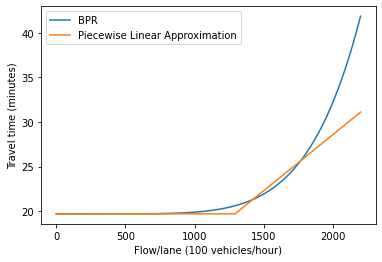

In [6]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Generate Demand Profile:

In [7]:
###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.02 (1.2 $/hr), 0.24 (14.399999999999999 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 44.4 $/hr; median: 33.6 $/hr


Text(0, 0.5, '% of population')

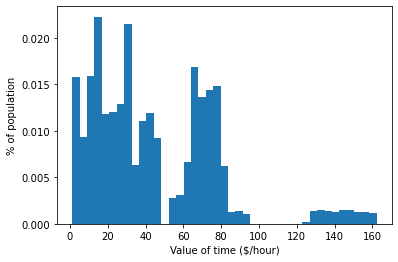

In [8]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

# Define Social Objectives of Interest:

In [9]:
###### Estimate VoT percentiles for ineligible group ###### 
percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)

12.63
18.54
23.18
29.92
33.78
43.75
63.46
68.42
74.5
80.04
162.23


## To modify below (See marking)

In [27]:
demand_multiplier = [25,75]

###### Evaluate Travel Time Metrics ###### 
def evaluate_avg_tt_in_budget(solution_, demand_multiplier):
    """
    Average travel time, ineligible only
    """
    
    ineligible_tt = sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) * apx_bpr_cost(solution_['edge_flows'][0, t],
                                                                    capacity = bpr_true_capacity * demand_multiplier[0],
                                                                    b = apx_slope / demand_multiplier[0])
                                 for i in range(num_ineligible) for t in range(T))/(T * num_ineligible)
    ineligible_tt += sum( solution_['users_in'][i, 2, t] * apx_bpr_cost(solution_['edge_flows'][1, t],
                                                                    capacity = bpr_true_capacity * demand_multiplier[1],
                                                                    b = apx_slope / demand_multiplier[1])
                                 for i in range(num_ineligible) for t in range(T))/(T * num_ineligible)
    
    return ineligible_tt

def evaluate_avg_tt_el_budget(solution_, demand_multiplier):
    """
    Average travel time, eligible only
    """
    
    ## Frank: Not sure in the original code, why one needs to divide by num_eligible twice. 
    # Express lane:
    eligible_tt = sum(( (solution_['users_el'][0, t] + solution_['users_el'][1, t]) /num_eligible)*apx_bpr_cost(solution_['edge_flows'][0, t],
                                                               capacity = bpr_true_capacity * demand_multiplier[0],
                                                               b = apx_slope / demand_multiplier[0])
                                for t in range(T)) /(T * num_eligible)
    
    # General-purpose lane:
    eligible_tt += sum((solution_['users_el'][2, t]/num_eligible)*apx_bpr_cost(solution_['edge_flows'][1, t],
                                                               capacity = bpr_true_capacity * demand_multiplier[1],
                                                               b = apx_slope / demand_multiplier[1])
                                for t in range(T)) /(T * num_eligible)
    
    return eligible_tt

def evaluate_total_tt_budget(solution_,demand_multiplier):
    """
    Total travel time
    """
    ineligible_tt = evaluate_avg_tt_in_budget(solution_, demand_multiplier) * num_ineligible * T
    eligible_tt = evaluate_avg_tt_el_budget(solution_, demand_multiplier) * num_eligible * T
    
    return eligible_tt + ineligible_tt

def evaluate_avg_travel_time_budget(solution_,demand_multiplier):
    """
    Average travel time
    """
    return evaluate_total_tt_budget(solution_,demand_multiplier)/(T*num_total)

def evaluate_avg_express_tt_budget(solution_,demand_multiplier):
    """
    Average travel time on express lane
    """
    avg_EL_tt = sum(apx_bpr_cost(solution_['edge_flows'][0, t],capacity = bpr_true_capacity*demand_multiplier[0],
                                 b = apx_slope/demand_multiplier[0]) for t in range(T))/T
    return avg_EL_tt

def evaluate_avg_general_tt_budget(solution_,demand_multiplier):
    """
    Average travel time on general purpose lanes
    """
    avg_GP_tt = sum(apx_bpr_cost(solution_['edge_flows'][1, t],capacity = bpr_true_capacity*demand_multiplier[1],
                                 b = apx_slope/demand_multiplier[1]) for t in range(T))/T
    return avg_GP_tt
    
def evaluate_avg_tt_savings_budget(solution_,demand_multiplier):
    """
    Average travel time savings   
    """
    delta_tt = sum(apx_bpr_cost(solution_['edge_flows'][1, t],capacity = bpr_true_capacity*demand_multiplier[1],
                                 b = apx_slope/demand_multiplier[1]) - 
                   apx_bpr_cost(solution_['edge_flows'][0, t],capacity = bpr_true_capacity*demand_multiplier[0],
                                b = apx_slope/demand_multiplier[0]) for t in range(T))/T
    return delta_tt


###### Evaluate Lane Usage Metrics ###### 
def evaluate_express_usage_budget(solution_,demand_multiplier):
    """
    Average share of all/el/inel users using express lane
    """
    share_eligible = sum( (solution_['users_el'][0, t] + solution_['users_el'][1, t]) for t in range(T))/(T * num_eligible)
    share_ineligible = sum((solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t])  for i in range(num_ineligible) for t in range(T))/(T * num_ineligible)
    share_all = (sum(solution_['users_el'][0, t] for t in range(T)) +
               sum(solution_['users_in'][i, 0, t] for i in range(num_ineligible) for t in range(T)) +
                sum(solution_['users_el'][1, t] for t in range(T)) +
               sum(solution_['users_in'][i, 1, t] for i in range(num_ineligible) for t in range(T)) )/(T * num_total)
    
    return share_all, share_eligible, share_ineligible


def evaluate_express_usage_percentile_inel_budget(solution_,demand_multiplier,percentiles):
    share_ineligible = {}
    for p,thresh in percentiles.items():
        # number of ineligible users in the group
        if p >= 10:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0]) for t in range(T))
        else:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60)))[0]) for t in range(T))
        
        share_ineligible[p] = 0
        for t in range(T):
            if p>=10:
                share_ineligible[p]+=sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) 
                                         for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                           (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0])
            else:
                share_ineligible[p]+=sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t])
                                         for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0])
        if these_ineligible > 0:
            share_ineligible[p]=share_ineligible[p]/these_ineligible
    
    return share_ineligible


###### Evaluate Travel Cost Metrics ###### 
def evaluate_total_travel_cost_in_budget(solution_, tau, demand_multiplier):
    
    """
    Total travel cost for ineligible only
    """
    
    ineligible_travel_cost = sum((solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) * vot_ineligible[i, t]*apx_bpr_cost(solution_['edge_flows'][0, t],
                                                                                                  capacity = bpr_true_capacity*demand_multiplier[0],
                                                                                                  b = apx_slope/demand_multiplier[0])
                                 for i in range(num_ineligible) for t in range(T))
    ineligible_travel_cost += sum(solution_['users_in'][i, 2, t]*vot_ineligible[i, t]*apx_bpr_cost(solution_['edge_flows'][1, t],
                                                                                                  capacity = bpr_true_capacity*demand_multiplier[1],
                                                                                                  b = apx_slope/demand_multiplier[1])
                                 for i in range(num_ineligible) for t in range(T))
    
    toll_revenue_in = evaluate_total_revenue_in_budget(solution_, tau, demand_multiplier)
    return ineligible_travel_cost + toll_revenue_in


def evaluate_total_travel_cost_el_budget(solution_, tau, demand_multiplier):
    
    """
    Total travel cost for eligible only
    """
    
    eligible_travel_cost = sum(( (solution_['users_el'][0, t] + solution_['users_el'][1, t]) /num_eligible)*vot_eligible[i, t]*apx_bpr_cost(solution_['edge_flows'][0, t],
                                                                                                           capacity = bpr_true_capacity*demand_multiplier[0],
                                                                                                           b = apx_slope/demand_multiplier[0])  
                               for i in range(num_eligible) for t in range(T))
    
    eligible_travel_cost += sum((solution_['users_el'][2, t]/num_eligible)*vot_eligible[i, t]*apx_bpr_cost(solution_['edge_flows'][1, t],
                                                                                                           capacity = bpr_true_capacity*demand_multiplier[1],
                                                                                                           b = apx_slope/demand_multiplier[1])  
                               for i in range(num_eligible) for t in range(T))
    
    toll_revenue_el = evaluate_total_revenue_el_budget(solution_, tau, demand_multiplier)
    
    return eligible_travel_cost + toll_revenue_el

def evaluate_total_revenue_in_budget(solution_, tau, demand_multiplier):
    """
    Total toll revenue from ineligible users 
    """
    total_toll_revenue_in = sum(tau * solution_['users_in'][i, 1, t] for i in range(num_ineligible) for t in range(T))
    
    return total_toll_revenue_in

def evaluate_total_revenue_el_budget(solution_, tau, demand_multiplier):
    """
    Total toll revenue from eligible users
    """
    total_toll_revenue_el = sum(tau * solution_['users_el'][1, t] for t in range(T))
    
    return total_toll_revenue_el


def evaluate_total_travel_cost_percentile_inel_budget(solution_,tau,demand_multiplier,percentiles):
    """
    Total travel cost for each ineligible group percentile
    """
    social_cost={}
    for p,thresh in percentiles.items():
        social_cost[p]=0
        for t in range(T):
            if p>=10:
                social_cost[p]+=sum(solution_['users_in'][i, j, t]*vot_ineligible[i, t]*apx_bpr_cost(
                    solution_['edge_flows'][j, t],capacity = bpr_true_capacity*demand_multiplier[j], b = apx_slope/demand_multiplier[j]) 
                                    for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                      (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0] for j in range(2))
                
                social_cost[p]+=sum(solution_['users_in'][i, 0, t]*tau for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                                                         (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0] )
            else:
                social_cost[p]+=sum(solution_['users_in'][i, j, t]*vot_ineligible[i, t]*apx_bpr_cost(
                    solution_['edge_flows'][j, t],capacity = bpr_true_capacity*demand_multiplier[j],b = apx_slope/demand_multiplier[j])
                                    for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0] for j in range(2))
                social_cost[p]+=sum(solution_['users_in'][i, 0, t]*tau for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0])
    return social_cost

def evaluate_avg_travel_cost_percentile_inel_budget(social_cost_by_percentile):
    """
    Average travel cost for each ineligible group percentile  
    """
    avg_social_cost={}
    for p,thresh in percentiles.items():
        if p >=10:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0]) for t in range(T))
        else:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60)))[0]) for t in range(T))
        if these_ineligible>0:
            avg_social_cost[p]=social_cost_by_percentile[p]/these_ineligible
        else:
            avg_social_cost[p]=0
    return avg_social_cost

# Solver 1, Budget:

In [28]:
def OptPL_budget(toll, B, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
#     users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = 0.0, ub = 2.0)
#     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = 0.0, ub = num_ineligible * 2.0)
#     users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = 0.0, ub = 2.0)
    # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    
#     # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)
    users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = -10000.0, ub = 10000.0)   

    ## Add constraints to Model 
    
    # Total edge flow, express lane:
    m1.addConstrs((edge_flows[0, t] == sum(users_in[i, 0, t] for i in range(num_ineligible)) + \
                  users_el[0, t] + sum(users_in[i, 1, t] for i in range(num_ineligible)) + \
                  users_el[1, t] for t in range(T)))
    # Total edge flow, general purpose lane:
    m1.addConstrs((edge_flows[1, t] == sum(users_in[i, 2, t] for i in range(num_ineligible)) + \
                  users_el[2, t] for t in range(T)))
    
    # Non-negativity of flows, and zero flow for "eligible users in ineligible groups":
    m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(3) for t in range(T)))
    m1.addConstrs((users_in[i, 0, t]==0 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((users_el[j, t]>=0 for j in range(3) for t in range(T)))
#     # Just to compare with original code:
#     m1.addConstrs((users_el[1, t]==0 for t in range(T)))
    
    # Every eligible and ineligible user is assigned to one of three options: \
    # (express paying, express with credit, non-express)
    m1.addConstrs((sum(users_in[i, j, t] for j in range(3)) == 1 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((sum(users_el[j, t] for j in range(3)) == num_eligible for t in range(T)))
    
    # Budget constraint satisfaction:
    if toll != 0:
        m1.addConstr((sum(toll*users_el[0, t] for t in range(T)) <= B * num_eligible))
        
    # Piecewise affine approximation:
    m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity
    
    # Set Objective
    m1.setObjective(sum( a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2  
                        + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( toll*users_in[i,1,t]/vot_ineligible[i,t] for i in range(num_ineligible)) 
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [29]:
def _extract_solution_budget(m, num_ineligible = num_ineligible):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 3, T))
    users_el = np.reshape(users_el, (3, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

In [30]:
# vot_eligible[:, 0]

In [31]:
# Solver 2, Discount:

def OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
#     users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = 0.0, ub = 2.0)
#     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = 0.0, ub = num_ineligible * 2.0)
#     users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = 0.0, ub = 2.0)
    # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    
#     # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    users_in = m1.addVars(num_ineligible, 2, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)
    users_el = m1.addVars(2, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = -10000.0, ub = 10000.0)   

    ## Add constraints to Model 
    
    # Total edge flow, express and general purpose lanes:
    m1.addConstrs((edge_flows[j, t] == sum(users_in[i, j, t] for i in range(num_ineligible)) + \
                  users_el[j, t] for j in range(2) for t in range(T)))
    
    # Non-negativity of flows, and zero flow for "eligible users in ineligible groups":
    m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(2) for t in range(T)))
    m1.addConstrs((users_el[j, t]>=0 for j in range(2) for t in range(T)))
    
    # Every eligible and ineligible user is assigned to one of three options: \
    # (express paying, express with credit, non-express)
    m1.addConstrs((sum(users_in[i, j, t] for j in range(2)) == 1 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((sum(users_el[j, t] for j in range(2)) == num_eligible for t in range(T)))
        
    # Piecewise affine approximation:
    m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity
    
    
    ## To edit below:
    # Set Objective
    m1.setObjective(sum( a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2  
                        + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( toll*users_in[i,0,t]/vot_ineligible[i,t] for i in range(num_ineligible))
                        + sum( (1 - discount_ratio)*toll*users_el[0,t]/vot_eligible[i,t] for i in range(num_eligible))
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [32]:
def _extract_solution_discount(m, num_ineligible = num_ineligible):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 2, T))
    users_el = np.reshape(users_el, (2, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

In [ ]:
def to_str(num):
    num = int(num)
    
    # For any number < 100:
    if num < 10:
        return str(0) + str(num)
    else:
        return str(num)

# Solve Optimization Problem for Discretized Grid:

## Case 1 - Budget (Gurobi):

In [33]:
###### Initialize matrices for results ###### 
# Optimization problems are iterated over tolls budgets

avg_tt_in_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_el_budget = np.zeros((len(tau_arr), len(B_arr)))
total_tt_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_EL_tt_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_GP_tt_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_savings_budget = np.zeros((len(tau_arr), len(B_arr)))

exp_all_budget = np.zeros((len(tau_arr), len(B_arr)))
exp_el_budget = np.zeros((len(tau_arr), len(B_arr)))
exp_in_budget = np.zeros((len(tau_arr), len(B_arr)))
exp_in_p_budget = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}

total_tc_in_budget = np.zeros((len(tau_arr), len(B_arr)))
total_tc_el_budget = np.zeros((len(tau_arr), len(B_arr)))
total_tr_budget = np.zeros((len(tau_arr), len(B_arr)))
total_tc_in_p_budget = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}
avg_tc_in_p_budget = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}

In [46]:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
# print(tau_arr)
# print()
# print(B_arr)
# print()

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

[ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]



In [45]:
t_1 = time.time()

demand_multiplier = [25,75]

# Copied from above:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 

# # For debugging:
tau_arr = np.array([5]) # Toll discretization
B_arr = np.array([3]) # Budget discretization

# tau_arr = np.array([5, 6, 7]) # Toll discretization
# B_arr = np.array([3, 4, 5]) # Budget discretization


total_count = len(tau_arr) * len(B_arr)


for toll_idx, toll in enumerate(tau_arr):
    for budget_idx, budget in enumerate(B_arr):
        m_budget = OptPL_budget(toll, budget, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
                    vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
                      fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
                     a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

        m_budget.optimize()
        
        # Extract Solution:
        solution_set = _extract_solution_budget(m_budget)
        
        if toll == tau_arr[0]:
            print()
            print("Edge flows:", solution_set["edge_flows"])
            print()
        
        # Extract Metrics:
        
        ### Frank - To modify below:
        
        avg_tt_in_budget[toll_idx, budget_idx] = evaluate_avg_tt_in_budget(solution_set, demand_multiplier)
        avg_tt_el_budget[toll_idx, budget_idx] = evaluate_avg_tt_el_budget(solution_set, demand_multiplier)
        total_tt_budget[toll_idx, budget_idx] = evaluate_total_tt_budget(solution_set,demand_multiplier)
        avg_tt_budget[toll_idx, budget_idx] = evaluate_avg_travel_time_budget(solution_set,demand_multiplier)
        avg_EL_tt_budget[toll_idx, budget_idx] = evaluate_avg_express_tt_budget(solution_set,demand_multiplier)
        avg_GP_tt_budget[toll_idx, budget_idx] = evaluate_avg_general_tt_budget(solution_set,demand_multiplier)
        avg_tt_savings_budget[toll_idx, budget_idx] = evaluate_avg_tt_savings_budget(solution_set,demand_multiplier)

        exp_all_budget[toll_idx, budget_idx], exp_el_budget[toll_idx, budget_idx], exp_in_budget[toll_idx, budget_idx] \
            = evaluate_express_usage_budget(solution_set,demand_multiplier)

        total_tc_in_budget[toll_idx, budget_idx] = evaluate_total_travel_cost_in_budget(solution_set, toll, demand_multiplier)
        total_tc_el_budget[toll_idx, budget_idx] = evaluate_total_travel_cost_el_budget(solution_set, toll, demand_multiplier)
        total_tr_budget[toll_idx, budget_idx] = evaluate_total_revenue_in_budget(solution_set, toll, demand_multiplier) \
            + evaluate_total_revenue_el_budget(solution_set, toll, demand_multiplier)
        
        share_inel_all_budget = evaluate_express_usage_percentile_inel_budget(solution_set,demand_multiplier,percentiles)
        total_social_cost_inel_all_budget = evaluate_total_travel_cost_percentile_inel_budget(solution_set,toll,demand_multiplier,percentiles)
        avg_social_cost_inel_all_budget = evaluate_avg_travel_cost_percentile_inel_budget(total_social_cost_inel_all_budget)
        for p in range(11):
            exp_in_p_budget[p*10][toll_idx,budget_idx] = share_inel_all_budget[p*10]
            total_tc_in_p_budget[p*10][toll_idx,budget_idx] = total_social_cost_inel_all_budget[p*10]
            avg_tc_in_p_budget[p*10][toll_idx,budget_idx] = avg_social_cost_inel_all_budget[p*10]
            
        # Store information:
        
        
        
        
        


t_2 = time.time()
print("Run time:", t_2 - t_1)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x814d3ca2
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.22s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         P

Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+03]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.17s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.20591617e+09 -4.28269983e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -1.05781580e+05 -1.33708253e+07  6.35e+03 5.63e-01  1.19e+03     0s
   2   1.19497454e+06 -3.22308943e+06  1.50e+02 1.33e-02  8.78e+01     0s
   3   9.89241650e+05 -3.75067120e+05  1.74e+01 1.55e-03  2.14e+01     0s
   4   9.22276177e+05  7.

   8   8.87757476e+05  8.37929323e+05  2.10e-01 1.86e-05  7.52e-01     0s
   9   8.68137698e+05  8.47133029e+05  4.11e-02 3.64e-06  3.16e-01     0s
  10   8.60614469e+05  8.56028738e+05  3.43e-03 3.04e-07  6.90e-02     0s
  11   8.59693042e+05  8.56976991e+05  1.34e-03 1.19e-07  4.09e-02     0s
  12   8.58783069e+05  8.58066467e+05  2.75e-04 2.43e-08  1.08e-02     0s
  13   8.58776141e+05  8.58073959e+05  2.69e-04 2.38e-08  1.06e-02     0s
  14   8.58733137e+05  8.58118278e+05  2.35e-04 2.08e-08  9.25e-03     0s
  15   8.58705913e+05  8.58145864e+05  2.14e-04 1.90e-08  8.43e-03     0s
  16   8.58655708e+05  8.58195509e+05  1.76e-04 1.56e-08  6.92e-03     0s
  17   8.58617633e+05  8.58230289e+05  1.32e-04 1.17e-08  5.83e-03     0s
  18   8.58579605e+05  8.58265737e+05  9.42e-05 8.34e-09  4.72e-03     0s
  19   8.58532220e+05  8.58311000e+05  5.70e-05 5.04e-09  3.33e-03     0s
  20   8.58493466e+05  8.58348231e+05  3.24e-05 2.87e-09  2.18e-03     0s
  21   8.58473053e+05  8.58368106e+05 

   0  -3.09162589e+09 -4.27716274e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -9.13220203e+05 -1.32019684e+07  6.36e+03 5.63e-01  1.19e+03     0s
   2   1.21088375e+06 -3.16315476e+06  1.41e+02 1.25e-02  8.61e+01     0s
   3   1.03007135e+06 -5.49370245e+05  3.10e+01 2.75e-03  2.57e+01     0s
   4   9.44273403e+05  7.45632557e+05  2.59e+00 2.30e-04  3.03e+00     0s
   5   8.96321346e+05  7.96257410e+05  7.81e-01 6.92e-05  1.52e+00     0s
   6   8.80471177e+05  8.15573982e+05  3.73e-01 3.30e-05  9.82e-01     0s
   7   8.89907588e+05  8.25413616e+05  3.30e-01 2.93e-05  9.74e-01     0s
   8   8.67733970e+05  8.49088414e+05  5.66e-02 5.01e-06  2.81e-01     0s
   9   8.61176222e+05  8.57176915e+05  6.60e-03 5.84e-07  6.02e-02     0s
  10   8.59699017e+05  8.58751148e+05  1.75e-08 5.90e-13  1.43e-02     0s
  11   8.59273625e+05  8.59239473e+05  2.57e-07 8.53e-14  5.14e-04     0s
  12   8.59253495e+05  8.59253459e+05  2.28e-05 1.14e-13  6.72e-07     0s
  13   8.59253473e+05  8.59253473e+05 

In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()

In [36]:
solution_gurobi = _extract_solution_budget(m_budget)

print(solution_gurobi["edge_flows"])
print()
print(solution_gurobi["eps_flows"])



[[1955.59573958 1955.55487957 1955.4584716  1955.55285327 1955.51156658]
 [6044.40426044 6044.44512043 6044.5415284  6044.44714673 6044.48843342]]

[[ 662.82073958  662.77987957  662.6834716   662.77785327  662.73656658]
 [2166.07926044 2166.12012043 2166.2165284  2166.12214673 2166.16343342]]


In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)



## Case 2 - Discount (Gurobi):

In [ ]:
time_1 = time.time()


demand_multiplier = [25,75]

# num_ineligible_trunc = num_ineligible

# Truncating num_ineligible to enable comparison with CVXPY (which is very, very slow):
# num_ineligible_trunc = 200
# num_ineligible_trunc = int(num_ineligible/3)
num_ineligible_trunc = num_ineligible
discount_ratio = budget/(toll*T)

# toll = 1.0
# budget = 3.0

# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()


m_discount = OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible_trunc, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

m_discount.optimize()

time_2 = time.time()
print("Run time:", time_2 - time_1)

In [ ]:
solution_discount = _extract_solution_discount(m_discount)

In [ ]:
print(solution_discount["edge_flows"])
print()
print(solution_discount["eps_flows"])



# Scratch Work:

In [ ]:
# 20*np.linspace(0, 1, 21)[0:]
# np.linspace(toll_arr[0], toll_arr[-3]*T,19)